# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [19:23<00:00, 51.6File/s]  


Extracting celeba...


KeyboardInterrupt: 

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

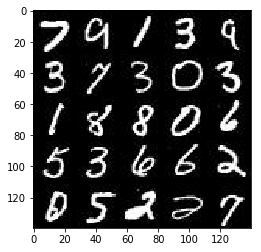

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

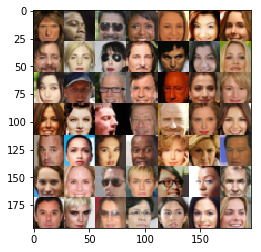

In [5]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, img_width, img_height, img_channels = data_shape
    real_input, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3625... Generator Loss: 4.6791
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 1.8313
Epoch 1/2... Discriminator Loss: 0.4821... Generator Loss: 1.6958
Epoch 1/2... Discriminator Loss: 0.4246... Generator Loss: 1.8056
Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 4.7864
Epoch 1/2... Discriminator Loss: 0.7948... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 0.1085... Generator Loss: 3.0667
Epoch 1/2... Discriminator Loss: 0.4749... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 5.2057
Epoch 1/2... Discriminator Loss: 2.1444... Generator Loss: 9.3179


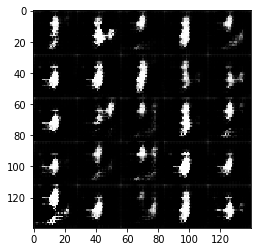

Epoch 1/2... Discriminator Loss: 0.3476... Generator Loss: 2.2826
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 3.5810
Epoch 1/2... Discriminator Loss: 0.3442... Generator Loss: 1.7530
Epoch 1/2... Discriminator Loss: 0.4398... Generator Loss: 3.3945
Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 4.6509
Epoch 1/2... Discriminator Loss: 1.5659... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 1.0832
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 2.9820
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 1.0324
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.5227


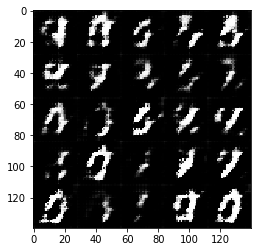

Epoch 1/2... Discriminator Loss: 0.4156... Generator Loss: 2.8817
Epoch 1/2... Discriminator Loss: 0.4709... Generator Loss: 1.5521
Epoch 1/2... Discriminator Loss: 0.4932... Generator Loss: 2.7221
Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 2.0950
Epoch 1/2... Discriminator Loss: 0.8816... Generator Loss: 1.5307
Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 1.3864
Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 2.2988
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 0.6641
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 2.4934
Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 0.9946


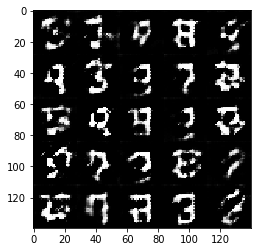

Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 2.4440
Epoch 1/2... Discriminator Loss: 2.2254... Generator Loss: 5.3119
Epoch 1/2... Discriminator Loss: 0.9490... Generator Loss: 3.0239
Epoch 1/2... Discriminator Loss: 0.7345... Generator Loss: 1.8628
Epoch 1/2... Discriminator Loss: 0.6763... Generator Loss: 2.4984
Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 1.6453
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 1.4184
Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 1.8617
Epoch 1/2... Discriminator Loss: 1.0367... Generator Loss: 2.5035
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 2.2494


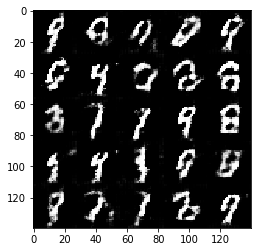

Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 1.0253
Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 1.9668
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.9270
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 1.0259
Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 2.0663
Epoch 1/2... Discriminator Loss: 0.7492... Generator Loss: 1.4773
Epoch 1/2... Discriminator Loss: 1.0522... Generator Loss: 2.5629
Epoch 1/2... Discriminator Loss: 0.6726... Generator Loss: 2.3971


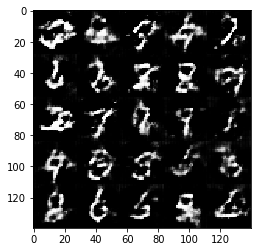

Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 1.0936
Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 0.8034... Generator Loss: 1.0794
Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 0.8101... Generator Loss: 1.8719
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 1.4306
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 0.7278... Generator Loss: 1.7829


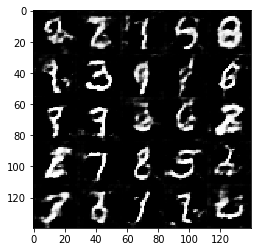

Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 0.9803... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 0.6715... Generator Loss: 1.7991
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 0.8704... Generator Loss: 1.8963
Epoch 1/2... Discriminator Loss: 0.9100... Generator Loss: 1.0899
Epoch 1/2... Discriminator Loss: 0.6076... Generator Loss: 1.5167
Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 1.7214
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.7173


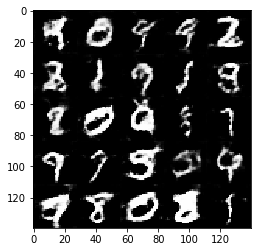

Epoch 1/2... Discriminator Loss: 1.2543... Generator Loss: 0.5654
Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 1.2143... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 0.9109... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 0.7984... Generator Loss: 1.4510
Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 1.1031
Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.2404
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 1.4942
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 0.7748
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.6032


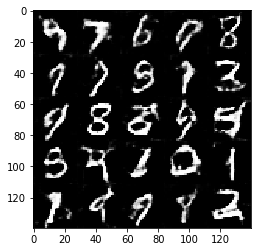

Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 0.7490... Generator Loss: 1.2266
Epoch 1/2... Discriminator Loss: 1.2864... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.7806
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 1.5267
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.4348
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.3576
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 0.6090


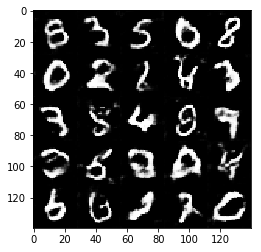

Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 1.5474
Epoch 1/2... Discriminator Loss: 1.8065... Generator Loss: 0.3443
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.5408
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.1503
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 1.5920
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 2.3763
Epoch 2/2... Discriminator Loss: 0.6325... Generator Loss: 1.3479
Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 0.7150
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.0456


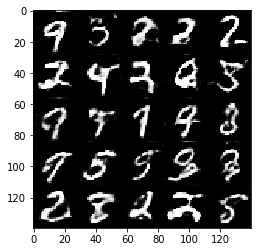

Epoch 2/2... Discriminator Loss: 1.5273... Generator Loss: 0.3574
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 1.9997
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.6936
Epoch 2/2... Discriminator Loss: 1.2992... Generator Loss: 2.2025
Epoch 2/2... Discriminator Loss: 1.5093... Generator Loss: 0.4167
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.7060
Epoch 2/2... Discriminator Loss: 1.0184... Generator Loss: 1.6186
Epoch 2/2... Discriminator Loss: 2.2501... Generator Loss: 0.1771
Epoch 2/2... Discriminator Loss: 0.9425... Generator Loss: 0.7097


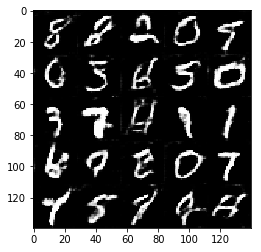

Epoch 2/2... Discriminator Loss: 2.5512... Generator Loss: 0.1122
Epoch 2/2... Discriminator Loss: 1.4792... Generator Loss: 2.2092
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.1409
Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 0.8505... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.9807... Generator Loss: 3.3540
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 2.9236
Epoch 2/2... Discriminator Loss: 0.7942... Generator Loss: 1.4786
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.5491


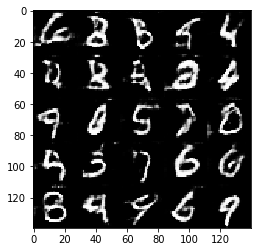

Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 2.3637
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.4686
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.4223
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 1.1660
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 1.6904... Generator Loss: 0.3191
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 0.6510
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 0.7320


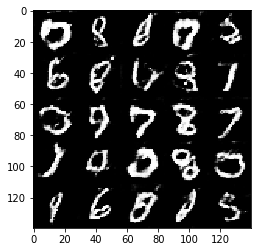

Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 4.1897
Epoch 2/2... Discriminator Loss: 0.6471... Generator Loss: 1.5405
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 0.9708
Epoch 2/2... Discriminator Loss: 0.7729... Generator Loss: 1.4002
Epoch 2/2... Discriminator Loss: 1.5361... Generator Loss: 0.4022
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.1883
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 1.1380
Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 0.8541


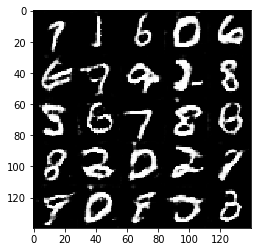

Epoch 2/2... Discriminator Loss: 0.7636... Generator Loss: 2.0982
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 0.9378
Epoch 2/2... Discriminator Loss: 1.0231... Generator Loss: 0.8743
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 0.6513
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 0.6641... Generator Loss: 1.3051
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 1.1785
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 1.1406
Epoch 2/2... Discriminator Loss: 1.1531... Generator Loss: 0.6982
Epoch 2/2... Discriminator Loss: 1.6790... Generator Loss: 0.3059


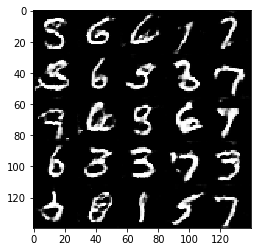

Epoch 2/2... Discriminator Loss: 0.8201... Generator Loss: 1.1541
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 1.5782
Epoch 2/2... Discriminator Loss: 0.6879... Generator Loss: 1.2098
Epoch 2/2... Discriminator Loss: 1.7261... Generator Loss: 0.3429
Epoch 2/2... Discriminator Loss: 0.5301... Generator Loss: 2.1192
Epoch 2/2... Discriminator Loss: 0.6331... Generator Loss: 1.8616
Epoch 2/2... Discriminator Loss: 1.6276... Generator Loss: 0.3649
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 0.5618... Generator Loss: 1.1324
Epoch 2/2... Discriminator Loss: 1.5122... Generator Loss: 0.3520


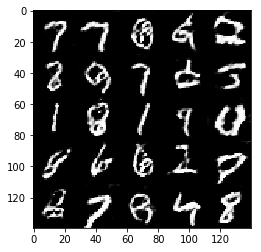

Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 1.3172
Epoch 2/2... Discriminator Loss: 0.8270... Generator Loss: 1.6365
Epoch 2/2... Discriminator Loss: 1.0524... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 1.1242
Epoch 2/2... Discriminator Loss: 2.1720... Generator Loss: 0.2614
Epoch 2/2... Discriminator Loss: 0.6368... Generator Loss: 1.1458
Epoch 2/2... Discriminator Loss: 0.7903... Generator Loss: 0.9384
Epoch 2/2... Discriminator Loss: 0.5362... Generator Loss: 3.0761
Epoch 2/2... Discriminator Loss: 1.8735... Generator Loss: 0.4236
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.3763


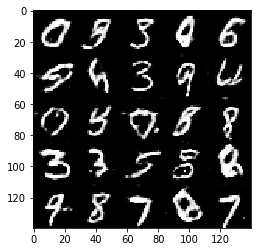

Epoch 2/2... Discriminator Loss: 1.6190... Generator Loss: 0.3555
Epoch 2/2... Discriminator Loss: 1.5610... Generator Loss: 0.3936
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 1.2162
Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 2.7053
Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.0720
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 2.5438
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.5310
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 1.1922
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.8164


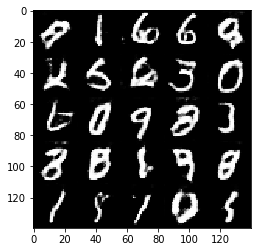

Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 1.3408
Epoch 2/2... Discriminator Loss: 1.2083... Generator Loss: 0.5418
Epoch 2/2... Discriminator Loss: 2.1143... Generator Loss: 4.9866
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 2.3532... Generator Loss: 0.2276
Epoch 2/2... Discriminator Loss: 0.9319... Generator Loss: 0.7231


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/15... Discriminator Loss: 0.4167... Generator Loss: 1.8716
Epoch 1/15... Discriminator Loss: 0.2725... Generator Loss: 13.7252
Epoch 1/15... Discriminator Loss: 0.4440... Generator Loss: 14.5959
Epoch 1/15... Discriminator Loss: 0.1877... Generator Loss: 11.1088
Epoch 1/15... Discriminator Loss: 1.0315... Generator Loss: 0.4974
Epoch 1/15... Discriminator Loss: 0.1850... Generator Loss: 2.2918
Epoch 1/15... Discriminator Loss: 3.4501... Generator Loss: 0.0429
Epoch 1/15... Discriminator Loss: 2.0712... Generator Loss: 0.3813
Epoch 1/15... Discriminator Loss: 0.3245... Generator Loss: 3.8752
Epoch 1/15... Discriminator Loss: 0.4495... Generator Loss: 2.2569


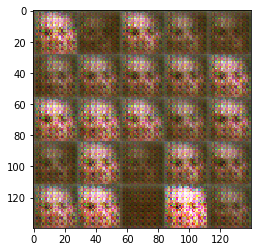

Epoch 1/15... Discriminator Loss: 0.4106... Generator Loss: 3.1364
Epoch 1/15... Discriminator Loss: 0.4848... Generator Loss: 1.8098
Epoch 1/15... Discriminator Loss: 0.8805... Generator Loss: 1.1743
Epoch 1/15... Discriminator Loss: 0.3082... Generator Loss: 1.9075
Epoch 1/15... Discriminator Loss: 0.4982... Generator Loss: 4.6765
Epoch 2/15... Discriminator Loss: 0.8828... Generator Loss: 0.6762
Epoch 2/15... Discriminator Loss: 0.4405... Generator Loss: 2.7023
Epoch 2/15... Discriminator Loss: 2.0204... Generator Loss: 0.1958
Epoch 2/15... Discriminator Loss: 0.3709... Generator Loss: 1.9063
Epoch 2/15... Discriminator Loss: 1.3932... Generator Loss: 0.5855


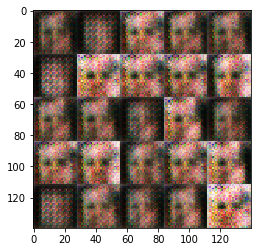

Epoch 2/15... Discriminator Loss: 0.4050... Generator Loss: 3.3424
Epoch 2/15... Discriminator Loss: 0.8576... Generator Loss: 3.8721
Epoch 2/15... Discriminator Loss: 0.8419... Generator Loss: 0.8869
Epoch 2/15... Discriminator Loss: 2.2686... Generator Loss: 0.1801
Epoch 2/15... Discriminator Loss: 1.1138... Generator Loss: 1.7375
Epoch 2/15... Discriminator Loss: 1.4285... Generator Loss: 0.7976
Epoch 2/15... Discriminator Loss: 2.0972... Generator Loss: 0.6905
Epoch 2/15... Discriminator Loss: 1.0111... Generator Loss: 0.7172
Epoch 2/15... Discriminator Loss: 0.6961... Generator Loss: 1.9225
Epoch 2/15... Discriminator Loss: 1.0280... Generator Loss: 1.2781


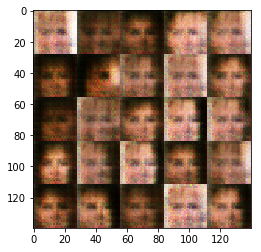

Epoch 3/15... Discriminator Loss: 0.7683... Generator Loss: 1.2122
Epoch 3/15... Discriminator Loss: 1.2265... Generator Loss: 1.1187
Epoch 3/15... Discriminator Loss: 1.0138... Generator Loss: 1.5675
Epoch 3/15... Discriminator Loss: 0.8491... Generator Loss: 0.9058
Epoch 3/15... Discriminator Loss: 0.6092... Generator Loss: 1.2527
Epoch 3/15... Discriminator Loss: 0.3886... Generator Loss: 2.9788
Epoch 3/15... Discriminator Loss: 1.0179... Generator Loss: 3.1381
Epoch 3/15... Discriminator Loss: 0.6026... Generator Loss: 2.7299
Epoch 3/15... Discriminator Loss: 1.0379... Generator Loss: 4.0810
Epoch 3/15... Discriminator Loss: 1.0292... Generator Loss: 0.8184


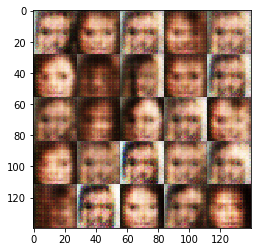

Epoch 3/15... Discriminator Loss: 0.6456... Generator Loss: 1.5243
Epoch 3/15... Discriminator Loss: 0.7055... Generator Loss: 3.0786
Epoch 3/15... Discriminator Loss: 0.8278... Generator Loss: 1.4859
Epoch 3/15... Discriminator Loss: 1.1405... Generator Loss: 0.7019
Epoch 3/15... Discriminator Loss: 0.9586... Generator Loss: 1.0378
Epoch 4/15... Discriminator Loss: 1.2332... Generator Loss: 0.5440
Epoch 4/15... Discriminator Loss: 0.9218... Generator Loss: 1.0684
Epoch 4/15... Discriminator Loss: 1.8126... Generator Loss: 0.3955
Epoch 4/15... Discriminator Loss: 0.6887... Generator Loss: 1.2372
Epoch 4/15... Discriminator Loss: 0.6654... Generator Loss: 1.5394


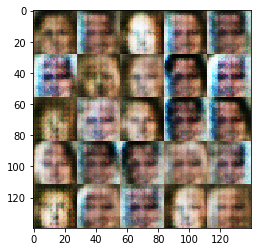

Epoch 4/15... Discriminator Loss: 1.1265... Generator Loss: 0.9777
Epoch 4/15... Discriminator Loss: 0.8313... Generator Loss: 1.1998
Epoch 4/15... Discriminator Loss: 0.8946... Generator Loss: 0.9494
Epoch 4/15... Discriminator Loss: 0.7877... Generator Loss: 2.2329
Epoch 4/15... Discriminator Loss: 0.9616... Generator Loss: 0.9184
Epoch 4/15... Discriminator Loss: 0.9700... Generator Loss: 1.0011
Epoch 4/15... Discriminator Loss: 0.8181... Generator Loss: 1.5021
Epoch 4/15... Discriminator Loss: 1.0233... Generator Loss: 0.8057
Epoch 4/15... Discriminator Loss: 0.6769... Generator Loss: 1.7346
Epoch 4/15... Discriminator Loss: 0.4739... Generator Loss: 1.5101


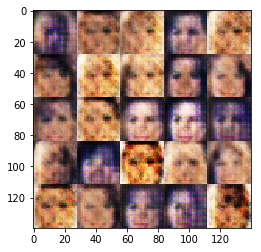

Epoch 5/15... Discriminator Loss: 0.6796... Generator Loss: 1.5991
Epoch 5/15... Discriminator Loss: 0.7638... Generator Loss: 1.2003
Epoch 5/15... Discriminator Loss: 0.8566... Generator Loss: 0.9542
Epoch 5/15... Discriminator Loss: 0.7936... Generator Loss: 1.4966
Epoch 5/15... Discriminator Loss: 1.0038... Generator Loss: 0.7233
Epoch 5/15... Discriminator Loss: 0.9435... Generator Loss: 0.9272
Epoch 5/15... Discriminator Loss: 0.8061... Generator Loss: 1.8696
Epoch 5/15... Discriminator Loss: 0.6546... Generator Loss: 2.6031
Epoch 5/15... Discriminator Loss: 0.8293... Generator Loss: 1.7718
Epoch 5/15... Discriminator Loss: 1.5214... Generator Loss: 3.3006


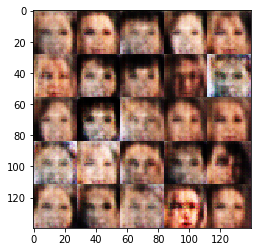

Epoch 5/15... Discriminator Loss: 1.0191... Generator Loss: 1.6693
Epoch 5/15... Discriminator Loss: 0.9673... Generator Loss: 2.4594
Epoch 5/15... Discriminator Loss: 0.8965... Generator Loss: 1.1811
Epoch 5/15... Discriminator Loss: 0.9561... Generator Loss: 0.9574
Epoch 5/15... Discriminator Loss: 0.8533... Generator Loss: 0.8842
Epoch 6/15... Discriminator Loss: 0.8562... Generator Loss: 0.9695
Epoch 6/15... Discriminator Loss: 0.8859... Generator Loss: 0.8987
Epoch 6/15... Discriminator Loss: 0.7437... Generator Loss: 1.4471
Epoch 6/15... Discriminator Loss: 0.9360... Generator Loss: 1.2138
Epoch 6/15... Discriminator Loss: 0.9835... Generator Loss: 1.4926


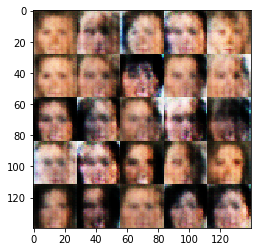

Epoch 6/15... Discriminator Loss: 1.0838... Generator Loss: 0.7883
Epoch 6/15... Discriminator Loss: 0.9480... Generator Loss: 0.8397
Epoch 6/15... Discriminator Loss: 0.8826... Generator Loss: 1.0473
Epoch 6/15... Discriminator Loss: 1.0487... Generator Loss: 0.8318
Epoch 6/15... Discriminator Loss: 0.7637... Generator Loss: 1.1669
Epoch 6/15... Discriminator Loss: 0.9800... Generator Loss: 1.3054
Epoch 6/15... Discriminator Loss: 0.9148... Generator Loss: 1.4674
Epoch 6/15... Discriminator Loss: 1.0064... Generator Loss: 0.9181
Epoch 6/15... Discriminator Loss: 0.7479... Generator Loss: 1.4471
Epoch 6/15... Discriminator Loss: 1.2221... Generator Loss: 0.4842


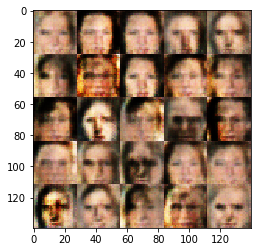

Epoch 7/15... Discriminator Loss: 0.8745... Generator Loss: 1.8018
Epoch 7/15... Discriminator Loss: 1.1171... Generator Loss: 1.3379
Epoch 7/15... Discriminator Loss: 0.8572... Generator Loss: 1.1542
Epoch 7/15... Discriminator Loss: 0.8868... Generator Loss: 0.9949
Epoch 7/15... Discriminator Loss: 0.8648... Generator Loss: 1.4760
Epoch 7/15... Discriminator Loss: 0.6284... Generator Loss: 1.0988
Epoch 7/15... Discriminator Loss: 0.9281... Generator Loss: 0.8679
Epoch 7/15... Discriminator Loss: 0.8571... Generator Loss: 1.0704
Epoch 7/15... Discriminator Loss: 0.6995... Generator Loss: 1.2909
Epoch 7/15... Discriminator Loss: 1.0128... Generator Loss: 1.0237


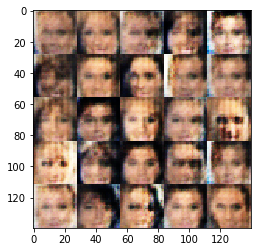

Epoch 7/15... Discriminator Loss: 0.8629... Generator Loss: 1.8099
Epoch 7/15... Discriminator Loss: 1.1636... Generator Loss: 0.6565
Epoch 7/15... Discriminator Loss: 0.9305... Generator Loss: 0.7840
Epoch 7/15... Discriminator Loss: 0.7833... Generator Loss: 1.0938
Epoch 7/15... Discriminator Loss: 0.9729... Generator Loss: 0.9250
Epoch 8/15... Discriminator Loss: 1.0046... Generator Loss: 2.0042
Epoch 8/15... Discriminator Loss: 1.1920... Generator Loss: 0.7084
Epoch 8/15... Discriminator Loss: 0.9401... Generator Loss: 1.5860
Epoch 8/15... Discriminator Loss: 0.6824... Generator Loss: 1.6809
Epoch 8/15... Discriminator Loss: 0.9669... Generator Loss: 1.5331


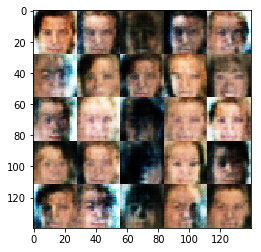

Epoch 8/15... Discriminator Loss: 0.9069... Generator Loss: 0.9850
Epoch 8/15... Discriminator Loss: 0.8984... Generator Loss: 1.4798
Epoch 8/15... Discriminator Loss: 0.8929... Generator Loss: 0.9774
Epoch 8/15... Discriminator Loss: 0.7799... Generator Loss: 1.2915
Epoch 8/15... Discriminator Loss: 0.8908... Generator Loss: 1.2388
Epoch 8/15... Discriminator Loss: 0.6315... Generator Loss: 1.6526
Epoch 8/15... Discriminator Loss: 0.8434... Generator Loss: 1.4987
Epoch 8/15... Discriminator Loss: 1.0666... Generator Loss: 0.9295
Epoch 8/15... Discriminator Loss: 0.7239... Generator Loss: 1.4667
Epoch 8/15... Discriminator Loss: 0.7667... Generator Loss: 1.1500


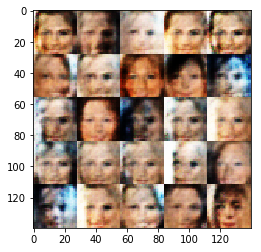

Epoch 9/15... Discriminator Loss: 0.8354... Generator Loss: 1.4771
Epoch 9/15... Discriminator Loss: 1.2405... Generator Loss: 0.5691
Epoch 9/15... Discriminator Loss: 0.6735... Generator Loss: 1.5858
Epoch 9/15... Discriminator Loss: 0.5989... Generator Loss: 1.3376
Epoch 9/15... Discriminator Loss: 0.6927... Generator Loss: 1.5879
Epoch 9/15... Discriminator Loss: 0.9325... Generator Loss: 0.9921
Epoch 9/15... Discriminator Loss: 0.9763... Generator Loss: 0.9812
Epoch 9/15... Discriminator Loss: 0.5681... Generator Loss: 2.0657
Epoch 9/15... Discriminator Loss: 0.9018... Generator Loss: 1.3323
Epoch 9/15... Discriminator Loss: 0.7818... Generator Loss: 1.6706


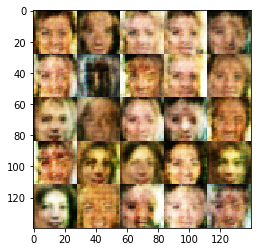

Epoch 9/15... Discriminator Loss: 0.7304... Generator Loss: 1.4935
Epoch 9/15... Discriminator Loss: 1.0917... Generator Loss: 0.7225
Epoch 9/15... Discriminator Loss: 0.7917... Generator Loss: 0.9720
Epoch 9/15... Discriminator Loss: 0.8675... Generator Loss: 1.9214
Epoch 9/15... Discriminator Loss: 0.7688... Generator Loss: 1.3393
Epoch 10/15... Discriminator Loss: 1.0229... Generator Loss: 0.9430
Epoch 10/15... Discriminator Loss: 0.6838... Generator Loss: 1.4445
Epoch 10/15... Discriminator Loss: 0.8420... Generator Loss: 0.8982
Epoch 10/15... Discriminator Loss: 1.8473... Generator Loss: 0.2594
Epoch 10/15... Discriminator Loss: 0.9391... Generator Loss: 1.8604


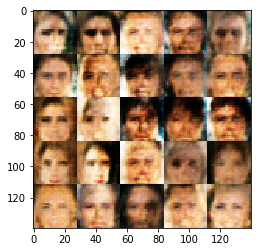

Epoch 10/15... Discriminator Loss: 1.2743... Generator Loss: 0.6157
Epoch 10/15... Discriminator Loss: 1.0444... Generator Loss: 0.9980
Epoch 10/15... Discriminator Loss: 1.0090... Generator Loss: 0.8421
Epoch 10/15... Discriminator Loss: 0.7242... Generator Loss: 1.7191
Epoch 10/15... Discriminator Loss: 1.0299... Generator Loss: 0.7018
Epoch 10/15... Discriminator Loss: 0.8124... Generator Loss: 1.5148
Epoch 10/15... Discriminator Loss: 0.8310... Generator Loss: 0.9838
Epoch 10/15... Discriminator Loss: 0.8474... Generator Loss: 1.4363
Epoch 10/15... Discriminator Loss: 1.2024... Generator Loss: 0.5116
Epoch 10/15... Discriminator Loss: 0.9285... Generator Loss: 1.0713


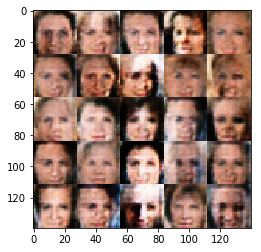

Epoch 10/15... Discriminator Loss: 0.9106... Generator Loss: 1.5188
Epoch 11/15... Discriminator Loss: 1.0334... Generator Loss: 0.6687
Epoch 11/15... Discriminator Loss: 0.9276... Generator Loss: 2.1822
Epoch 11/15... Discriminator Loss: 1.0654... Generator Loss: 0.7254
Epoch 11/15... Discriminator Loss: 0.8596... Generator Loss: 1.0897
Epoch 11/15... Discriminator Loss: 1.9643... Generator Loss: 3.2879
Epoch 11/15... Discriminator Loss: 0.8496... Generator Loss: 0.9768
Epoch 11/15... Discriminator Loss: 0.7720... Generator Loss: 1.4353
Epoch 11/15... Discriminator Loss: 0.7095... Generator Loss: 1.5673
Epoch 11/15... Discriminator Loss: 0.8409... Generator Loss: 1.4745


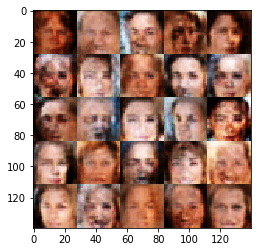

Epoch 11/15... Discriminator Loss: 0.8882... Generator Loss: 1.3330
Epoch 11/15... Discriminator Loss: 1.0089... Generator Loss: 1.0449
Epoch 11/15... Discriminator Loss: 0.8301... Generator Loss: 1.1268
Epoch 11/15... Discriminator Loss: 0.8114... Generator Loss: 0.8491
Epoch 11/15... Discriminator Loss: 1.0469... Generator Loss: 0.6469
Epoch 11/15... Discriminator Loss: 0.9443... Generator Loss: 1.0674
Epoch 12/15... Discriminator Loss: 1.1027... Generator Loss: 0.7343
Epoch 12/15... Discriminator Loss: 0.8010... Generator Loss: 1.0017
Epoch 12/15... Discriminator Loss: 0.8479... Generator Loss: 1.3774
Epoch 12/15... Discriminator Loss: 1.0873... Generator Loss: 0.8222


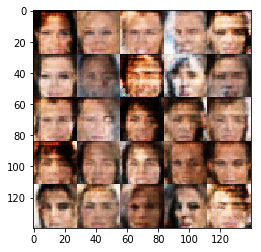

Epoch 12/15... Discriminator Loss: 0.8945... Generator Loss: 0.8541
Epoch 12/15... Discriminator Loss: 0.8906... Generator Loss: 0.8684
Epoch 12/15... Discriminator Loss: 1.0786... Generator Loss: 0.6548
Epoch 12/15... Discriminator Loss: 0.9872... Generator Loss: 0.8373
Epoch 12/15... Discriminator Loss: 2.0334... Generator Loss: 0.2230
Epoch 12/15... Discriminator Loss: 0.9281... Generator Loss: 0.9887
Epoch 12/15... Discriminator Loss: 1.0107... Generator Loss: 0.9340
Epoch 12/15... Discriminator Loss: 1.6890... Generator Loss: 0.2968
Epoch 12/15... Discriminator Loss: 0.8434... Generator Loss: 1.0791
Epoch 12/15... Discriminator Loss: 0.8581... Generator Loss: 0.9651


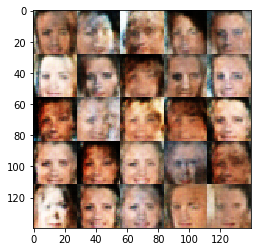

Epoch 12/15... Discriminator Loss: 0.8951... Generator Loss: 0.8285
Epoch 13/15... Discriminator Loss: 1.2429... Generator Loss: 0.7402
Epoch 13/15... Discriminator Loss: 0.7664... Generator Loss: 1.3733
Epoch 13/15... Discriminator Loss: 1.0896... Generator Loss: 0.7103
Epoch 13/15... Discriminator Loss: 0.6096... Generator Loss: 1.9960
Epoch 13/15... Discriminator Loss: 1.0104... Generator Loss: 0.7604
Epoch 13/15... Discriminator Loss: 0.6979... Generator Loss: 1.1063
Epoch 13/15... Discriminator Loss: 0.6064... Generator Loss: 1.9587
Epoch 13/15... Discriminator Loss: 0.7511... Generator Loss: 1.1269
Epoch 13/15... Discriminator Loss: 0.8360... Generator Loss: 1.1775


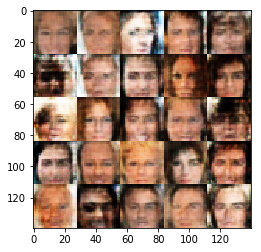

Epoch 13/15... Discriminator Loss: 0.7009... Generator Loss: 1.1941
Epoch 13/15... Discriminator Loss: 0.7471... Generator Loss: 1.6543
Epoch 13/15... Discriminator Loss: 1.4523... Generator Loss: 0.4082
Epoch 13/15... Discriminator Loss: 0.9271... Generator Loss: 1.4953
Epoch 13/15... Discriminator Loss: 0.9174... Generator Loss: 0.6965
Epoch 13/15... Discriminator Loss: 0.8035... Generator Loss: 1.5447
Epoch 14/15... Discriminator Loss: 0.7934... Generator Loss: 1.3865
Epoch 14/15... Discriminator Loss: 0.9038... Generator Loss: 0.8246
Epoch 14/15... Discriminator Loss: 1.5178... Generator Loss: 1.7864
Epoch 14/15... Discriminator Loss: 1.0698... Generator Loss: 0.6165


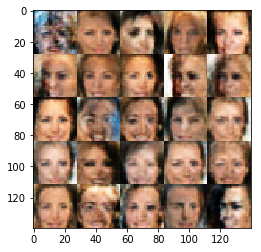

Epoch 14/15... Discriminator Loss: 0.7231... Generator Loss: 1.3810
Epoch 14/15... Discriminator Loss: 0.7420... Generator Loss: 1.2960
Epoch 14/15... Discriminator Loss: 0.8637... Generator Loss: 1.0521
Epoch 14/15... Discriminator Loss: 0.8245... Generator Loss: 0.9715
Epoch 14/15... Discriminator Loss: 1.3603... Generator Loss: 0.4186
Epoch 14/15... Discriminator Loss: 0.8239... Generator Loss: 1.3850
Epoch 14/15... Discriminator Loss: 1.2153... Generator Loss: 2.0725
Epoch 14/15... Discriminator Loss: 1.3363... Generator Loss: 1.5053
Epoch 14/15... Discriminator Loss: 0.8774... Generator Loss: 1.1957
Epoch 14/15... Discriminator Loss: 0.8476... Generator Loss: 0.9724


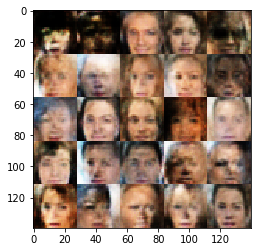

Epoch 14/15... Discriminator Loss: 0.8599... Generator Loss: 0.9857
Epoch 15/15... Discriminator Loss: 0.6543... Generator Loss: 1.1903
Epoch 15/15... Discriminator Loss: 1.0723... Generator Loss: 0.6303
Epoch 15/15... Discriminator Loss: 0.8216... Generator Loss: 1.1060
Epoch 15/15... Discriminator Loss: 0.9850... Generator Loss: 1.1821
Epoch 15/15... Discriminator Loss: 0.9601... Generator Loss: 0.8663
Epoch 15/15... Discriminator Loss: 1.2306... Generator Loss: 0.5135
Epoch 15/15... Discriminator Loss: 0.8778... Generator Loss: 2.1512
Epoch 15/15... Discriminator Loss: 0.9614... Generator Loss: 1.5735
Epoch 15/15... Discriminator Loss: 0.6151... Generator Loss: 2.5168


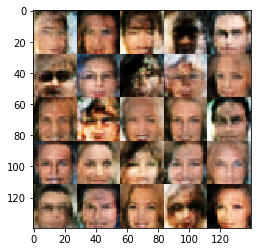

Epoch 15/15... Discriminator Loss: 0.7754... Generator Loss: 2.1741
Epoch 15/15... Discriminator Loss: 1.3991... Generator Loss: 2.7553
Epoch 15/15... Discriminator Loss: 0.7437... Generator Loss: 1.5177
Epoch 15/15... Discriminator Loss: 0.6635... Generator Loss: 1.2302
Epoch 15/15... Discriminator Loss: 1.1022... Generator Loss: 0.7247
Epoch 15/15... Discriminator Loss: 1.2324... Generator Loss: 0.4445


In [30]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 15

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.